# Tarea 3: Análisis Espectral (FFT) y Espectrogramas

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# Parámetros: ajusta fs según tus datos (Hz)
fs = 1000.0

path_clean = "Data/ener_clean.csv"
path_noise = "Data/ener_noise.csv"

df_clean = pd.read_csv(path_clean)
df_noise = pd.read_csv(path_noise)

# Columna específica a analizar (generación eólica)
col = "Ener_4"

if col not in df_clean.columns:
    raise ValueError(f"La columna '{col}' no está en ener_clean.csv. Columnas disponibles: {list(df_clean.columns)}")

if col not in df_noise.columns:
    raise ValueError(f"La columna '{col}' no está en ener_noise.csv. Columnas disponibles: {list(df_noise.columns)}")

x_clean = pd.to_numeric(df_clean[col], errors="coerce").dropna().to_numpy(dtype=float)
x_noise = pd.to_numeric(df_noise[col], errors="coerce").dropna().to_numpy(dtype=float)

n = min(len(x_clean), len(x_noise))
x_clean = x_clean[:n]
x_noise = x_noise[:n]

t = np.arange(n) / fs

print(f"Columna analizada: {col}")
print(f"Muestras usadas (clean/noise): {n}")

Columna analizada: Ener_4
Muestras usadas (clean/noise): 928


#### PSD (FFT) y comparación

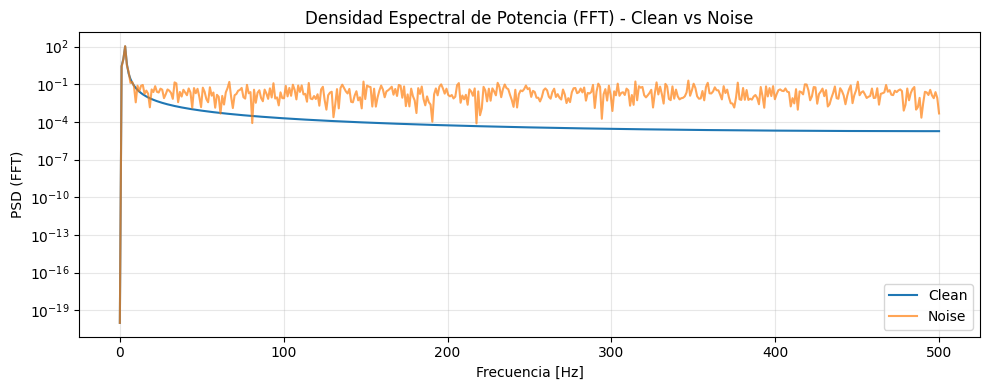

In [29]:
def compute_psd_fft(x, fs):
    n = len(x)
    x_detrended = x - np.mean(x)
    X = np.fft.rfft(x_detrended)
    psd = (np.abs(X)**2) / (n * fs)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    return freqs, psd

# PSD (FFT) de las series clean y noise
f_clean, psd_clean = compute_psd_fft(x_clean, fs)
f_noise, psd_noise = compute_psd_fft(x_noise, fs)

plt.figure(figsize=(10,4))
plt.semilogy(f_clean, psd_clean + 1e-20, label="Clean")
plt.semilogy(f_noise, psd_noise + 1e-20, label="Noise", alpha=0.7)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD (FFT)")
plt.title("Densidad Espectral de Potencia (FFT) - Clean vs Noise")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

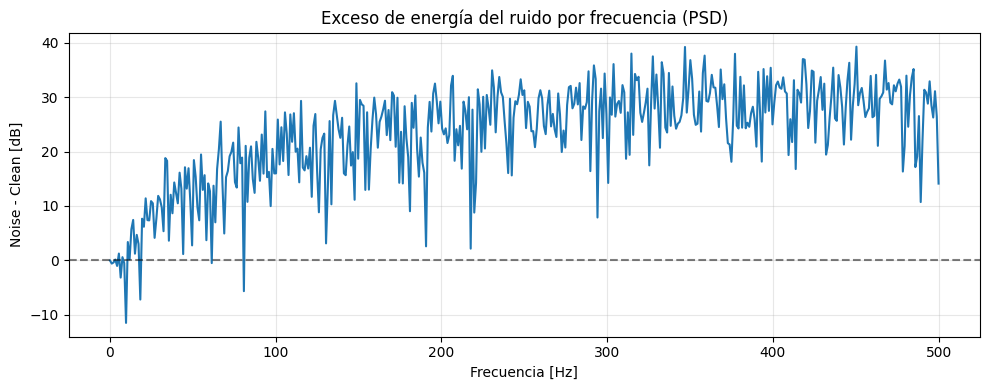

Rango con mayor ruido (> 3 dB sobre clean): 10.78–500.00 Hz


In [30]:
# Análisis de exceso de ruido por frecuencia usando PSD (FFT)
eps = 1e-20
psd_clean_db = 10*np.log10(psd_clean + eps)
psd_noise_db = 10*np.log10(psd_noise + eps)

psd_diff_db = psd_noise_db - psd_clean_db  # Noise - Clean en dB

plt.figure(figsize=(10,4))
plt.plot(f_clean, psd_diff_db)
plt.axhline(0, color="k", linestyle="--", alpha=0.5)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Noise - Clean [dB]")
plt.title("Exceso de energía del ruido por frecuencia (PSD)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Ejemplo: banda donde el ruido supera a la señal en más de umbral_db
umbral_db = 3
mask = psd_diff_db > umbral_db
if mask.any():
    f_min = f_clean[mask][0]
    f_max = f_clean[mask][-1]
    print(f"Rango con mayor ruido (> {umbral_db} dB sobre clean): {f_min:.2f}–{f_max:.2f} Hz")
else:
    print("No hay frecuencias donde Noise supere a Clean en más de 3 dB.")


#### Espectrogramas (clean vs noise)

Parámetros típicos: ajústalos si tu señal es muy corta/larga


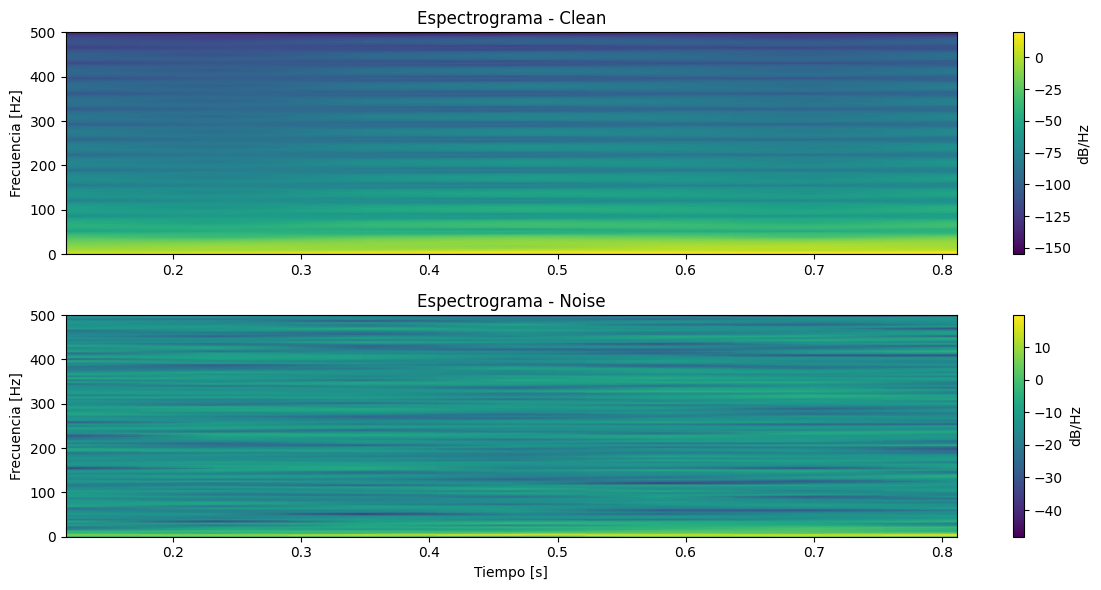

In [31]:
# Espectrogramas para las series clean y noise
nperseg = min(256, len(x_clean)//4) if len(x_clean) >= 64 else max(16, len(x_clean)//2)
noverlap = nperseg // 2

f_c, t_c, Sxx_clean = signal.spectrogram(x_clean, fs=fs, nperseg=nperseg, noverlap=noverlap)
f_n, t_n, Sxx_noise = signal.spectrogram(x_noise, fs=fs, nperseg=nperseg, noverlap=noverlap)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.pcolormesh(t_c, f_c, 10*np.log10(Sxx_clean + 1e-20), shading="gouraud")
plt.colorbar(label="dB/Hz")
plt.ylabel("Frecuencia [Hz]")
plt.title("Espectrograma - Clean")

plt.subplot(2,1,2)
plt.pcolormesh(t_n, f_n, 10*np.log10(Sxx_noise + 1e-20), shading="gouraud")
plt.colorbar(label="dB/Hz")
plt.xlabel("Tiempo [s]")
plt.ylabel("Frecuencia [Hz]")
plt.title("Espectrograma - Noise")
plt.tight_layout()
plt.show()

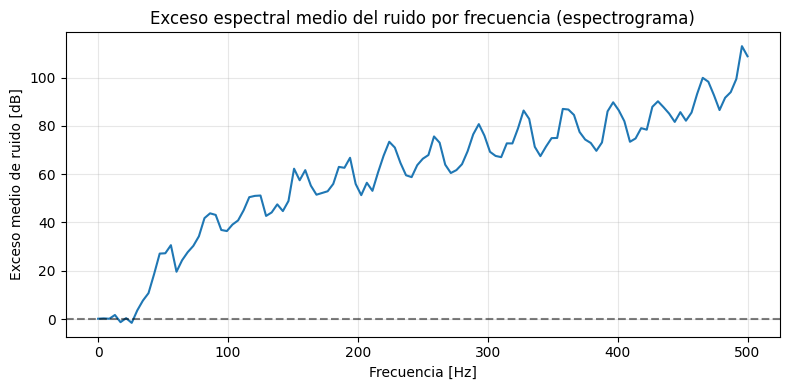

In [32]:
# Exceso espectral medio del ruido por frecuencia (a partir del espectrograma)
noise_excess_freq = S_diff.mean(axis=1)  # promedio sobre el tiempo para cada frecuencia

plt.figure(figsize=(8,4))
plt.plot(f_diff, noise_excess_freq)
plt.axhline(0, color="k", linestyle="--", alpha=0.5)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Exceso medio de ruido [dB]")
plt.title("Exceso espectral medio del ruido por frecuencia (espectrograma)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Comparación directa: exceso espectral en espectrograma

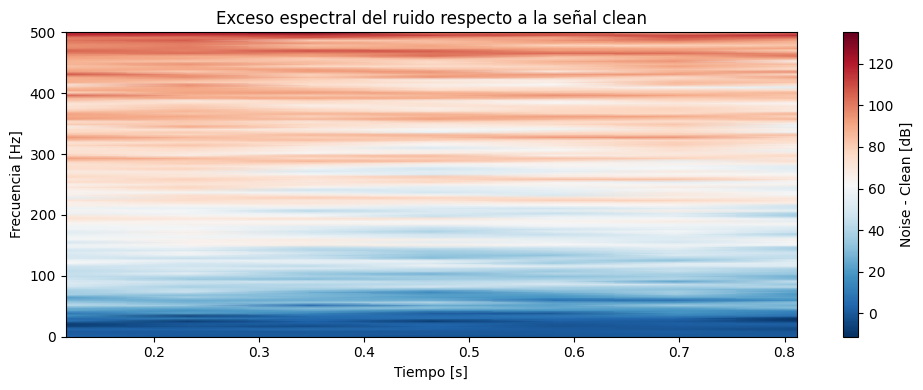

In [33]:
# Comparación directa: exceso espectral (Noise - Clean) en el espectrograma
min_f_bins = min(Sxx_clean.shape[0], Sxx_noise.shape[0])
min_t_bins = min(Sxx_clean.shape[1], Sxx_noise.shape[1])

S_clean_db = 10*np.log10(Sxx_clean[:min_f_bins, :min_t_bins] + 1e-20)
S_noise_db = 10*np.log10(Sxx_noise[:min_f_bins, :min_t_bins] + 1e-20)
S_diff = S_noise_db - S_clean_db

t_diff = t_c[:min_t_bins]
f_diff = f_c[:min_f_bins]

plt.figure(figsize=(10,4))
pcm = plt.pcolormesh(t_diff, f_diff, S_diff, shading="gouraud", cmap="RdBu_r")
plt.colorbar(pcm, label="Noise - Clean [dB]")
plt.xlabel("Tiempo [s]")
plt.ylabel("Frecuencia [Hz]")
plt.title("Exceso espectral del ruido respecto a la señal clean")
plt.tight_layout()
plt.show()

Pregunta: ¿En qué rango de frecuencias se concentra el ruido inyectado (SNR ∈ [5, 12]dB)?

Respuesta: Realmente basandome en los resultados obtenidos, logramos ver que incluso a bajas frecuencias se logra ver bastante ruido, ruido que no desparece en ningun momento, si debo elegir un rango en el cual colacar dicho ruido seria entre 0 y 50 Hz debido que al observar el grafico anterior notamos que la zona en la que la diferencia de ruido es mayor es a bajas frecuencias.

# Tarea 4: Filtrado y Reconstrucción

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

path_noise = "Data/agro_noise.csv"
path_clean = "Data/agro_clean.csv"
col = "Agro_3"

fs = 2000
cutoff_hz = 5
order = 4

df_noise = pd.read_csv(path_noise)
df_clean = pd.read_csv(path_clean)

if col not in df_noise.columns:
    raise ValueError(f"No encontré '{col}' en agro_noise.csv. Columnas disponibles: {list(df_noise.columns)}")

if col not in df_clean.columns:
    raise ValueError(f"No encontré '{col}' en agro_clean.csv. Columnas disponibles: {list(df_clean.columns)}")

x_noise = pd.to_numeric(df_noise[col], errors="coerce").dropna().to_numpy(dtype=float)
x_clean = pd.to_numeric(df_clean[col], errors="coerce").dropna().to_numpy(dtype=float)

n = min(len(x_noise), len(x_clean))
x_noise = x_noise[:n]
x_clean = x_clean[:n]

t = np.arange(n) / fs

print("Muestras (alineadas) noise/clean:", n)

Muestras (alineadas) noise/clean: 2000


#### FILTRO BUTTERWORTH PASO BAJO

In [35]:
nyq = fs / 2
Wn = cutoff_hz / nyq

if not (0 < Wn < 1):
    raise ValueError(f"cutoff_hz debe estar entre 0 y {nyq} Hz")

b, a = signal.butter(order, Wn, btype="low")
x_filtered = signal.filtfilt(b, a, x_noise)

####  RMSE (antes vs después)

RMSE (clean vs noise): 3.341434
RMSE (clean vs filtrada): 4.278410
Reducción de RMSE: -0.936976
RMSE (noise vs filtrada): 5.391936


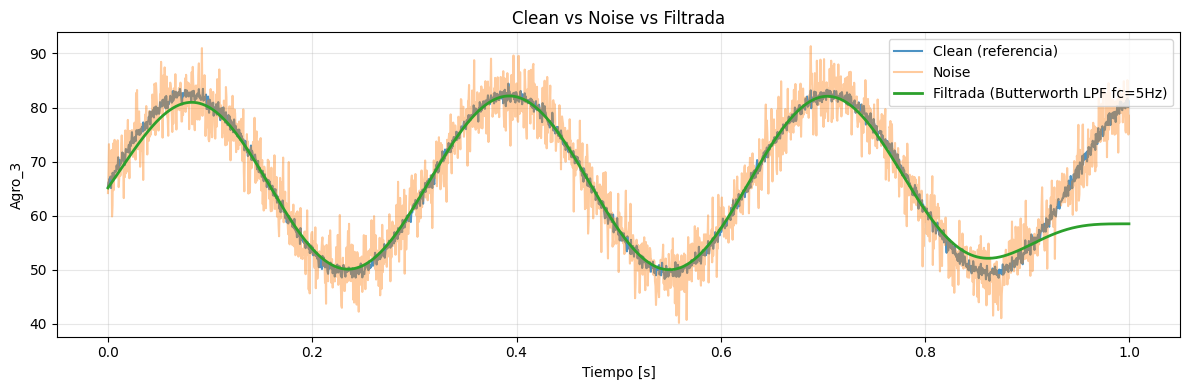

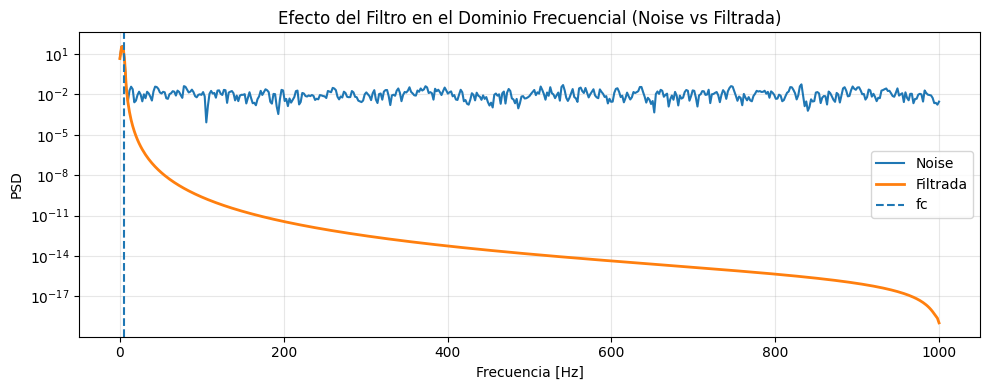

In [37]:
def rmse(x1, x2):
    return np.sqrt(np.mean((x1 - x2)**2))

rmse_before = rmse(x_clean, x_noise)
rmse_after = rmse(x_clean, x_filtered)
rmse_reduction = rmse_before - rmse_after
rmse_noise_filtered = rmse(x_noise, x_filtered)

print(f"RMSE (clean vs noise): {rmse_before:.6f}")
print(f"RMSE (clean vs filtrada): {rmse_after:.6f}")
print(f"Reducción de RMSE: {rmse_reduction:.6f}")
print(f"RMSE (noise vs filtrada): {rmse_noise_filtered:.6f}")

plt.figure(figsize=(12,4))
plt.plot(t, x_clean, label="Clean (referencia)", alpha=0.8)
plt.plot(t, x_noise, label="Noise", alpha=0.4)
plt.plot(t, x_filtered, label=f"Filtrada (Butterworth LPF fc={cutoff_hz}Hz)", linewidth=2)
plt.xlabel("Tiempo [s]")
plt.ylabel(col)
plt.title("Clean vs Noise vs Filtrada")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

f, P_noise = signal.welch(x_noise, fs=fs, nperseg=min(1024, len(x_noise)))
_, P_filtered = signal.welch(x_filtered, fs=fs, nperseg=min(1024, len(x_filtered)))

plt.figure(figsize=(10,4))
plt.semilogy(f, P_noise + 1e-20, label="Noise")
plt.semilogy(f, P_filtered + 1e-20, label="Filtrada", linewidth=2)
plt.axvline(cutoff_hz, linestyle="--", label="fc")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD")
plt.title("Efecto del Filtro en el Dominio Frecuencial (Noise vs Filtrada)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Pregunta: El filtrado mejora la capacidad predictiva del modelo?

Respuesta: El filtrado Butterworth de paso bajo con fc = 5 Hz no mejora la capacidad predictiva del modelo. Esto se observa en que el RMSE entre la serie limpia y la ruidosa es 3.34, mientras que el RMSE entre la serie limpia y la serie filtrada aumenta a 4.28. Es decir, el filtro distorsiona demasiado la señal de interés, alejándola de la serie original en lugar de aproximarla. Para que el filtrado ayudara, sería necesario reajustar los parámetros del filtro (frecuencia de corte, orden, etc.) en función del contenido espectral de la señal.